In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sample data for training the model (historical data)
# Data columns: Old Price, New Price, Old Quantity, New Quantity, PED (Price Elasticity of Demand), Revenue Change
data = {
    'Old_Price': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550,500],
    'New_Price': [90, 140, 190, 240, 280, 320, 380, 420, 480, 530,460],
    'Old_Quantity': [300, 150, 200, 250, 350, 400, 450, 500, 550, 600,700],
    'New_Quantity': [350, 160, 210, 260, 360, 420, 470, 520, 580, 630,650],
}

df = pd.DataFrame(data)

# Feature Engineering: Calculate percentage change in price and quantity
df['Price_Change'] = ((df['New_Price'] - df['Old_Price']) / df['Old_Price']) * 100
df['Quantity_Change'] = ((df['New_Quantity'] - df['Old_Quantity']) / df['Old_Quantity']) * 100

# Calculate PED (Price Elasticity of Demand)
df['PED'] = df['Quantity_Change'] / df['Price_Change']

# Target variable: Revenue Change
df['Revenue_Change'] = ((df['New_Price'] * df['New_Quantity']) - (df['Old_Price'] * df['Old_Quantity']))

# Print the DataFrame to check the records
df['Price_to_Quantity_Ratio'] = df['Old_Price'] / df['Old_Quantity']
df['Price_Quantity_Interaction'] = df['Old_Price'] * df['Old_Quantity']


df

,Old_Price,New_Price,Old_Quantity,New_Quantity,Price_Change,Quantity_Change,PED,Revenue_Change,Price_to_Quantity_Ratio,Price_Quantity_Interaction
0,100,90,300,350,-10.000000,16.666667,-1.666667,1500,0.333333,30000
1,150,140,150,160,-6.666667,6.666667,-1.000000,-100,1.000000,22500
2,200,190,200,210,-5.000000,5.000000,-1.000000,-100,1.000000,40000
3,250,240,250,260,-4.000000,4.000000,-1.000000,-100,1.000000,62500
4,300,280,350,360,-6.666667,2.857143,-0.428571,-4200,0.857143,105000
5,350,320,400,420,-8.571429,5.000000,-0.583333,-5600,0.875000,140000
6,400,380,450,470,-5.000000,4.444444,-0.888889,-1400,0.888889,180000
7,450,420,500,520,-6.666667,4.000000,-0.600000,-6600,0.900000,225000
8,500,480,550,580,-4.000000,5.454545,-1.363636,3400,0.909091,275000
9,550,530,600,630,-3.636364,5.000000,-1.375000,3900,0.916667,330000


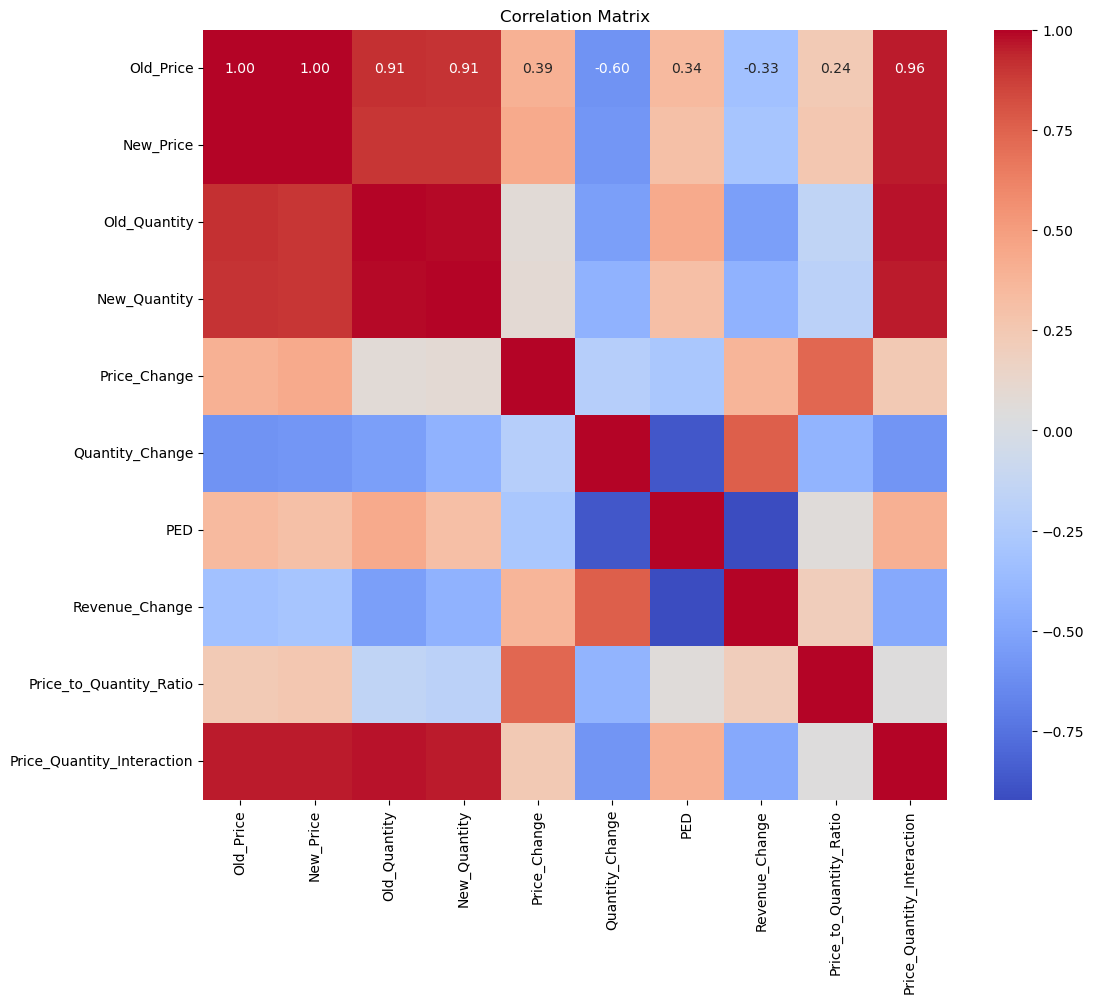

In [2]:
# Step 1: Handle Multicollinearity - Check correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix to visually check for high correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [3]:
# Step 2: Calculate Variance Inflation Factor (VIF)
# We will calculate VIF to check if any feature is highly collinear

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Remove target column for VIF calculation (replace 'Revenue' with the actual target column name)
X = df.drop('New_Price', axis=1)  # Replace 'Revenue' with your actual target column
vif_data = calculate_vif(X)

# Display features with high VIF (e.g., VIF > 10 suggests multicollinearity)
print(vif_data)

                      feature            VIF
0                   Old_Price   31244.959620
1                Old_Quantity  834031.716793
2                New_Quantity  997603.556823
3                Price_Change     509.701024
4             Quantity_Change    3016.544482
5                         PED     640.353317
6              Revenue_Change     474.416248
7     Price_to_Quantity_Ratio    5424.372252
8  Price_Quantity_Interaction    2345.228377


In [4]:
# Step 3: Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-Test Split
y = df['New_Price']  # Replace 'Revenue' with your actual target column
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
# Step 5: Apply Ridge Regression and find the best alpha using GridSearchCV
ridge = Ridge()
param_grid = {'alpha': np.logspace(-5, 5, 100)}  # Searching for alpha in a wide range
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Get the best alpha found by GridSearchCV
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha found by GridSearchCV: {best_alpha}")


Best alpha found by GridSearchCV: 0.00041320124001153346


In [6]:
# Step 6: Evaluate the model with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

# Predictions on the test set
y_pred = ridge_best.predict(X_test)

# Calculate Mean Absolute Error and R² score
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error for Revenue Model (Ridge): {mae}")
print(f"R² for Revenue Model (Ridge): {r2}")

Mean Absolute Error for Revenue Model (Ridge): 9.457212503998798
R² for Revenue Model (Ridge): 0.9934166337064276


In [8]:
# Step 7: Train-Test Split for PED Model
y_ped = df['PED']  # Target variable for PED model
X_train_ped, X_test_ped, y_train_ped, y_test_ped = train_test_split(X_scaled, y_ped, test_size=0.2, random_state=42)

# Step 8: Apply Ridge Regression for PED Model and find the best alpha using GridSearchCV
ridge_ped = Ridge()
param_grid_ped = {'alpha': np.logspace(-5, 5, 100)}  # Searching for alpha in a wide range
grid_search_ped = GridSearchCV(ridge_ped, param_grid_ped, cv=5, scoring='neg_mean_absolute_error')
grid_search_ped.fit(X_train_ped, y_train_ped)

# Get the best alpha for PED model
best_alpha_ped = grid_search_ped.best_params_['alpha']
print(f"Best alpha for PED Model found by GridSearchCV: {best_alpha_ped}")

# Step 9: Evaluate the PED Model with the best alpha
ridge_best_ped = Ridge(alpha=best_alpha_ped)
ridge_best_ped.fit(X_train_ped, y_train_ped)

# Predictions on the test set for PED model
y_pred_ped = ridge_best_ped.predict(X_test_ped)

# Calculate Mean Absolute Error and R² score for PED Model
mae_ped = mean_absolute_error(y_test_ped, y_pred_ped)
r2_ped = r2_score(y_test_ped, y_pred_ped)

# Print the results for PED Model
print(f"Mean Absolute Error for PED Model: {mae_ped}")
print(f"R² for PED Model: {r2_ped}")

Best alpha for PED Model found by GridSearchCV: 1e-05
Mean Absolute Error for PED Model: 0.06022170063294444
R² for PED Model: 0.9804963653824919


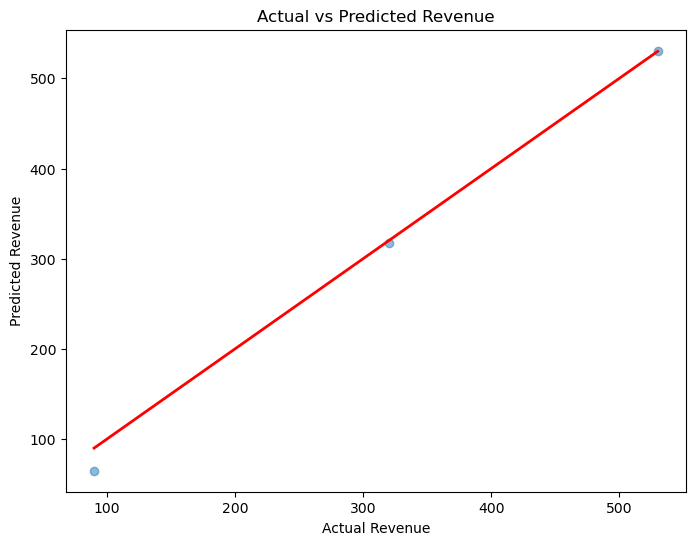

In [7]:
# Optional: Visualize Actual vs Predicted Revenue
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

In [9]:
import joblib

# Save the Ridge model for Revenue prediction
joblib.dump(ridge_best, 'ridge_best_model.pkl')

# Save the Ridge model for PED prediction
joblib.dump(ridge_best_ped, 'ridge_best_ped_model.pkl')

print("Models saved successfully!")


Models saved successfully!
